In [1]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

In [2]:
df=pd.read_parquet("ori_df.parquet")
df.columns

Index(['Tail_Number', 'prev_arr_dt', 'prev_arr_delay', 'prev_origin',
       'prev_dest', 'prev_crs_dep', 'prev_crs_arr', 'next_dep_dt', 'DepDelay',
       'next_origin', 'Dest', 'next_crs_dep', 'next_crs_arr', 'turn_time_min',
       'O-D', 'historical_turn_time_min_3mean', 'scheduled_turn_time',
       'realized slack', 'scheturn_bucket', 'prev_bin', 'op_carrier',
       'op_flight', 'Origin', 'carrier_slope', 'origin_slope', 'crsdep_hour',
       'dep_hour', 'prev_arr_hour', 'datetime', 'temperature_2m',
       'wind_speed_10m', 'wind_gusts_10m', 'precipitation', 'is_day',
       'cloud_cover', 'airport', 'datetime_pa', 'temperature_2m_pa',
       'wind_speed_10m_pa', 'wind_gusts_10m_pa', 'precipitation_pa',
       'is_day_pa', 'cloud_cover_pa', 'airport_pa', 'Distance',
       'DistanceGroup', 'CRSElapsedTime', 'DayOfWeek', 'dep_dt', 'FlightDate',
       'crsdep_tbin', 'prev_arr_tbin'],
      dtype='object')

In [3]:
y_label= "DepDelay"

numeric_cols = [
'prev_arr_delay',
 'historical_turn_time_min_3mean',
 'scheduled_turn_time',
 'realized slack',
 'carrier_slope',
 'origin_slope',
 'temperature_2m',
 'wind_speed_10m',
 'wind_gusts_10m',
 'precipitation',
 'cloud_cover',
 'temperature_2m_pa',
 'wind_speed_10m_pa',
 'wind_gusts_10m_pa',
 'precipitation_pa',
 'cloud_cover_pa',
 'Distance',
 'CRSElapsedTime',
]

cat_cols=[
 'prev_origin',
#  'prev_crs_arr',
 'Dest',
 'scheturn_bucket',
 'prev_bin',
 'op_carrier',
 'Origin',
#  'crsdep_hour',
 'prev_arr_tbin',
 'crsdep_tbin',
 'is_day',
'is_day_pa',
'DistanceGroup',
 'DayOfWeek']



In [4]:
import numpy as np
import pandas as pd

def add_advanced_features(df):
    df = df.copy()
    
    # 保证按时间排好（后面 rolling 必须基于时间）
    df = df.sort_values("FlightDate")
    
    # -----------------------
    # 1) 延误传播相关高阶特征
    # -----------------------
    # slack_time: 计划转场时间 - 历史平均转场时间（如果这个值小，说明这次周转很紧）
    df["slack_time"] = df["scheduled_turn_time"] - df["historical_turn_time_min_3mean"]
    
    # 确保 slack_time 有意义（负值可以保留，模型自己学）
    
    # prev_arr_delay 截断，避免极端值支配
    df["prev_arr_delay_clip"] = df["prev_arr_delay"].clip(lower=-30, upper=180)

    
# 把计划 turn time 限制在 [5, 180]，避免 0 和极端 overnight 的影响
    df["scheduled_turn_capped"] = df["scheduled_turn_time"].clip(lower=5, upper=180)

# 前序延误 / 计划周转 的比例，真正的“延误压力系数”
    df["prop_prev_delay_over_planned_turn"] = (
    df["prev_arr_delay_clip"] / df["scheduled_turn_capped"]
)
    


    # propagation ratio: 单位周转时间的迟到程度
    df["prop_prev_delay_over_turn"] = df["prev_arr_delay_clip"] / (df["scheduled_turn_time"] + 1e-3)
    
    # 短周转标记（比如 <45 分钟的转场）
    df["short_turn"] = (df["scheduled_turn_time"] < 45).astype(int)
    
    # 交互项：短周转 × 前序延误（捕捉“短周转下延误更容易传播”的非线性）
    df["short_turn_prev_delay"] = df["short_turn"] * df["prev_arr_delay_clip"]
    
    # -----------------------
    # 2) 天气变化 / 差分特征
    # 当前 vs 前一段（pa = previous arrival）
    # -----------------------
    df["wind_speed_diff"] = df["wind_speed_10m"] - df["wind_speed_10m_pa"]
    df["wind_gusts_diff"] = df["wind_gusts_10m"] - df["wind_gusts_10m_pa"]
    df["temp_diff"]       = df["temperature_2m"] - df["temperature_2m_pa"]
    df["precip_diff"]     = df["precipitation"] - df["precipitation_pa"]
    df["cloud_diff"]      = df["cloud_cover"] - df["cloud_cover_pa"]
    
    # 简单天气风险标记
    df["has_rain"] = (df["precipitation"] > 0.1).astype(int)
    df["has_rain_pa"] = (df["precipitation_pa"] > 0.1).astype(int)
    
    # -----------------------
    # 3) 航司 / 机场 / 航线的历史延误表现（rolling，没有泄露）
    # 使用 shift() 确保每行只看“之前的航班”
    # -----------------------
    # 3.1 按机场（Origin）过去 7 天平均 DepDelay
    df = df.sort_values(["Origin", "FlightDate"])
    df["origin_delay_mean_7d"] = (
        df.groupby("Origin")["DepDelay"]
          .transform(lambda x: x.shift().rolling(window=7, min_periods=3).mean())
    )
    
    # 3.2 按航司过去 7 天平均 DepDelay
    df = df.sort_values(["op_carrier", "FlightDate"])
    df["carrier_delay_mean_7d"] = (
        df.groupby("op_carrier")["DepDelay"]
          .transform(lambda x: x.shift().rolling(window=7, min_periods=3).mean())
    )
    
    # 3.3 航线级别：Origin-Dest 组合
    df["Route"] = df["Origin"] + "_" + df["Dest"]
    df = df.sort_values(["Route", "FlightDate"])
    df["route_delay_mean_7d"] = (
        df.groupby("Route")["DepDelay"]
          .transform(lambda x: x.shift().rolling(window=7, min_periods=5).mean())
    )
    
    # 对 rolling 产生的 NaN，用全局均值填充（表示没有足够历史）
    global_mean_delay = df["DepDelay"].mean()
    for col in ["origin_delay_mean_7d", "carrier_delay_mean_7d", "route_delay_mean_7d"]:
        df[col] = df[col].fillna(global_mean_delay)
    
    # -----------------------
    # 4) 一些简单的非线性变换
    # -----------------------
    # 距离 / 时间 的平均速度（航路速度粗略 proxy）
    df["avg_speed"] = df["Distance"] / (df["CRSElapsedTime"] + 1e-3)
    
    # 大延误 indicator（可辅助回归）
    df["prev_big_delay"] = (df["prev_arr_delay"] >= 30).astype(int)
    
    return df


In [5]:
df = add_advanced_features(df)

# 新增 numeric 特征
advanced_numeric = [
    "slack_time",
    "prev_arr_delay_clip",
    "prop_prev_delay_over_turn",
    "short_turn_prev_delay",
    "wind_speed_diff",
    "wind_gusts_diff",
    "temp_diff",
    "precip_diff",
    "cloud_diff",
    "origin_delay_mean_7d",
    "carrier_delay_mean_7d",
    "route_delay_mean_7d",
    "avg_speed",
]

# 新增 categorical 特征
advanced_cat = [
    "short_turn",      # 0/1 也可当类别
    "has_rain",
    "has_rain_pa",
    # "Route",
    "prev_big_delay",
]

numeric_cols_extended = numeric_cols + advanced_numeric
cat_cols_extended     = cat_cols + advanced_cat

features_extended = numeric_cols_extended + cat_cols_extended


In [6]:


import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# ------------ 基本设定 ------------
y_label = "DepDelay"

df_model = df.copy()
df_model = df_model[df_model[y_label].notna()].copy()#make sure y not nan
df_model["FlightDate"] = pd.to_datetime(df_model["FlightDate"])
df_model = df_model.sort_values("FlightDate")

# 时间切分（示例：前三周 train，中间一周 valid，最后几天 test）
train_end = "2025-01-21"
valid_end = "2025-01-28"

train = df_model[df_model["FlightDate"] <= train_end]
valid = df_model[(df_model["FlightDate"] > train_end) & (df_model["FlightDate"] <= valid_end)]
test  = df_model[df_model["FlightDate"] > valid_end]

X_train_raw, y_train = train[features_extended], train[y_label]
X_valid_raw, y_valid = valid[features_extended], valid[y_label]
X_test_raw,  y_test  = test[features_extended],  test[y_label]

print("Train:", X_train_raw.shape, "Valid:", X_valid_raw.shape, "Test:", X_test_raw.shape)



Train: (287832, 47) Valid: (96362, 47) Test: (42071, 47)


In [8]:
from pandas.api.types import CategoricalDtype


# ===== 3. 为每个类别列获取全局的 category 集合（用字符串） =====
cat_categories = {}
for col in cat_cols_extended:
    cat_categories[col] = (
        df_model[col]
        .astype(str)          # ⭐ 先转成字符串
        .astype("category")
        .cat.categories       # 得到全局所有可能取值
    )

def build_xgb_frame(X_raw: pd.DataFrame) -> pd.DataFrame:
    X = X_raw.copy()
    # 数值列强制为 float32
    for col in numeric_cols_extended:
        X[col] = X[col].astype("float32")
    # 类别列：先转成 str，再按全局 categories 转成 Categorical
    for col in cat_cols_extended:
        cat_type = CategoricalDtype(categories=cat_categories[col])
        X[col] = X[col].astype(str).astype(cat_type)
    return X

# 用同一个函数，把数值列→float32，类别列→category（全局 categories）
X_train_lgb = build_xgb_frame(X_train_raw)
X_valid_lgb = build_xgb_frame(X_valid_raw)
X_test_lgb  = build_xgb_frame(X_test_raw)

print(X_train_lgb.dtypes.head())


X_train_lgb.info()



prev_arr_delay                    float32
historical_turn_time_min_3mean    float32
scheduled_turn_time               float32
realized slack                    float32
carrier_slope                     float32
dtype: object
<class 'pandas.core.frame.DataFrame'>
Index: 287832 entries, 98177 to 273214
Data columns (total 47 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   prev_arr_delay                  287428 non-null  float32 
 1   historical_turn_time_min_3mean  282047 non-null  float32 
 2   scheduled_turn_time             287832 non-null  float32 
 3   realized slack                  287832 non-null  float32 
 4   carrier_slope                   287832 non-null  float32 
 5   origin_slope                    287354 non-null  float32 
 6   temperature_2m                  287832 non-null  float32 
 7   wind_speed_10m                  287832 non-null  float32 
 8   wind_gusts_10m                 

In [ ]:
# !pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 255.6 kB/s eta 0:00:00a 0:00:01


In [11]:
# ===== 4. 评估函数 =====
import lightgbm as lgb
def eval_regression(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n=== {name} ===")
    print(f"MAE : {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²  : {r2:.3f}")
    return mae, rmse, r2

# ===== Baseline LightGBM =====
lgb_baseline = lgb.LGBMRegressor(
    n_estimators=3000,
    learning_rate=0.05,
    num_leaves=63,          # 相当于 max_depth ~ 6
    max_depth=-1,           # 由 num_leaves 控制
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    objective="mae",        # 用 MAE 作为目标（L1）
    random_state=42,
    n_jobs=-1
)

lgb_baseline.fit(
    X_train_lgb,
    y_train,
    eval_set=[(X_valid_lgb, y_valid)],
    eval_metric="mae",
    categorical_feature=cat_cols_extended,
    callbacks=[
        lgb.early_stopping(stopping_rounds=80, verbose=True),
        lgb.log_evaluation(period=100)
    ]
)

print("Best iteration:", lgb_baseline.best_iteration_)

# 用 best_iteration_ 做预测（防止用到过拟合后期树）
y_valid_pred_lgb = lgb_baseline.predict(
    X_valid_lgb, num_iteration=lgb_baseline.best_iteration_
)
y_test_pred_lgb  = lgb_baseline.predict(
    X_test_lgb, num_iteration=lgb_baseline.best_iteration_
)

eval_regression(y_valid, y_valid_pred_lgb, "LightGBM Baseline - Valid")
eval_regression(y_test,  y_test_pred_lgb,  "LightGBM Baseline - Test")



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7522
[LightGBM] [Info] Number of data points in the train set: 287832, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -2.000000
Training until validation scores don't improve for 80 rounds
[100]	valid_0's l1: 6.97236
[200]	valid_0's l1: 6.75282
[300]	valid_0's l1: 6.67797
[400]	valid_0's l1: 6.65757
[500]	valid_0's l1: 6.65464
[600]	valid_0's l1: 6.65301
[700]	valid_0's l1: 6.65164
[800]	valid_0's l1: 6.65045
[900]	valid_0's l1: 6.64901
[1000]	valid_0's l1: 6.64804
Early stopping, best iteration is:
[1017]	valid_0's l1: 6.64783
Best iteration: 1017

=== LightGBM Baseline - Valid ===
MAE : 6.648
RMSE: 19.370
R²  : 0.6

(7.012996360743593, 22.699303679186286, 0.619642041442517)

In [12]:
import optuna

def objective_lgb(trial: optuna.Trial) -> float:
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),

        "num_leaves": trial.suggest_int("num_leaves", 31, 255),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 200),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 10.0, log=True),

        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),

        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),

        "objective": "mae",
        "random_state": 42,
        "n_jobs": -1,
    }

    model = lgb.LGBMRegressor(**params)

    model.fit(
        X_train_lgb,
        y_train,
        eval_set=[(X_valid_lgb, y_valid)],
        eval_metric="mae",
        categorical_feature=cat_cols_extended,
        callbacks=[lgb.early_stopping(stopping_rounds=80, verbose=False)]
    )

    y_valid_pred = model.predict(
        X_valid_lgb, num_iteration=model.best_iteration_
    )
    mae = mean_absolute_error(y_valid, y_valid_pred)
    return mae

study_lgb = optuna.create_study(
    direction="minimize", study_name="lightgbm_depdelay"
)
study_lgb.optimize(objective_lgb, n_trials=30, show_progress_bar=True)

print("\n===== Optuna LightGBM Tuning Result =====")
print("Best trial :", study_lgb.best_trial.number)
print("Best MAE   :", study_lgb.best_value)
print("Best params:", study_lgb.best_params)


[I 2025-12-10 01:24:16,798] A new study created in memory with name: lightgbm_depdelay


  0%|          | 0/30 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7522
[LightGBM] [Info] Number of data points in the train set: 287832, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -2.000000
[I 2025-12-10 01:24:45,293] Trial 0 finished with value: 6.673944998671099 and parameters: {'n_estimators': 2137, 'learning_rate': 0.0827982576978923, 'num_leaves': 177, 'min_child_samples': 65, 'min_child_weight': 0.0018088189733727596, 'subsample': 0.9262081671823219, 'colsample_bytree': 0.6006969955828558, 'reg_lambda': 9.627663152927644, 'reg_alpha': 0.5656254576130904}. Best is trial 0 with value: 6.673944998671099.
[LightGBM] [Warning] Found whitespace in feature_names, replace with un

In [13]:
# 先在 Train 上重训一个 tuned 模型，拿到 best_iteration_
best_params_lgb = study_lgb.best_params.copy()

lgb_tuned = lgb.LGBMRegressor(
    **best_params_lgb,
    objective="mae",
    random_state=42,
    n_jobs=-1
)

lgb_tuned.fit(
    X_train_lgb,
    y_train,
    eval_set=[(X_valid_lgb, y_valid)],
    eval_metric="mae",
    categorical_feature=cat_cols_extended,
    callbacks=[lgb.early_stopping(stopping_rounds=80, verbose=True)]
)

print("best_iteration_ (tuned):", lgb_tuned.best_iteration_)

# 在 Train+Valid 上训练 final 模型，锁定 n_estimators = best_iteration_
final_params_lgb = best_params_lgb.copy()
final_params_lgb["n_estimators"] = lgb_tuned.best_iteration_

lgb_final = lgb.LGBMRegressor(
    **final_params_lgb,
    objective="mae",
    random_state=42,
    n_jobs=-1
)

X_full_lgb = pd.concat([X_train_lgb, X_valid_lgb], axis=0)
y_full     = pd.concat([y_train, y_valid], axis=0)

lgb_final.fit(
    X_full_lgb,
    y_full,
    categorical_feature=cat_cols_extended
)

y_test_pred_lgb_final = lgb_final.predict(X_test_lgb)
eval_regression(y_test, y_test_pred_lgb_final, "LightGBM Final(Train+Valid) - Test")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7522
[LightGBM] [Info] Number of data points in the train set: 287832, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -2.000000
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1464]	valid_0's l1: 6.59726
best_iteration_ (tuned): 1464
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you ca

(6.89124661415091, 22.50264285952979, 0.6262041350302792)

In [14]:
df_imp = pd.DataFrame({
    "feature": lgb_final.feature_name_,
    "gain": lgb_final.booster_.feature_importance(importance_type="gain"),
    "split": lgb_final.booster_.feature_importance(importance_type="split"),
})

df_imp["gain_norm"] = df_imp["gain"] / df_imp["gain"].sum()
df_imp["split_norm"] = df_imp["split"] / df_imp["split"].sum()
df_imp["avg_rank"] = (df_imp["gain_norm"].rank(ascending=False) + df_imp["split_norm"].rank(ascending=False)) / 2

df_imp.sort_values("avg_rank").head(20)


,feature,gain,split,gain_norm,split_norm,avg_rank
31,prev_origin,1.297585e+06,57175,0.130617,0.175130,1.5
32,Dest,1.293088e+06,54316,0.130164,0.166373,3.0
36,Origin,1.295042e+06,46584,0.130361,0.142689,3.0
37,prev_arr_tbin,2.786049e+05,22222,0.028045,0.068067,5.5
35,op_carrier,5.465523e+05,11203,0.055017,0.034315,6.0
3,realized_slack,1.601299e+06,5548,0.161189,0.016994,7.0
38,crsdep_tbin,2.653071e+05,20265,0.026706,0.062073,7.0
28,carrier_delay_mean_7d,2.116509e+05,6450,0.021305,0.019757,9.5
20,prop_prev_delay_over_turn,1.179887e+06,5056,0.118769,0.015487,10.0
0,prev_arr_delay,2.719051e+05,5076,0.027370,0.015548,11.0


In [22]:
# Booster API always available
gain_imp = lgb_final.booster_.feature_importance(importance_type="gain")
split_imp = lgb_final.booster_.feature_importance(importance_type="split")

feature_names = lgb_final.booster_.feature_name()

import pandas as pd
imp_gain_df = pd.DataFrame({
    "feature": feature_names,
    "gain_importance": gain_imp,
    "split_importance": split_imp
}).sort_values("gain_importance", ascending=False)

imp_gain_df.head(20)


,feature,gain_importance,split_importance
3,realized_slack,1.601299e+06,5548
31,prev_origin,1.297585e+06,57175
36,Origin,1.295042e+06,46584
32,Dest,1.293088e+06,54316
20,prop_prev_delay_over_turn,1.179887e+06,5056
35,op_carrier,5.465523e+05,11203
37,prev_arr_tbin,2.786049e+05,22222
0,prev_arr_delay,2.719051e+05,5076
38,crsdep_tbin,2.653071e+05,20265
2,scheduled_turn_time,2.525664e+05,3859


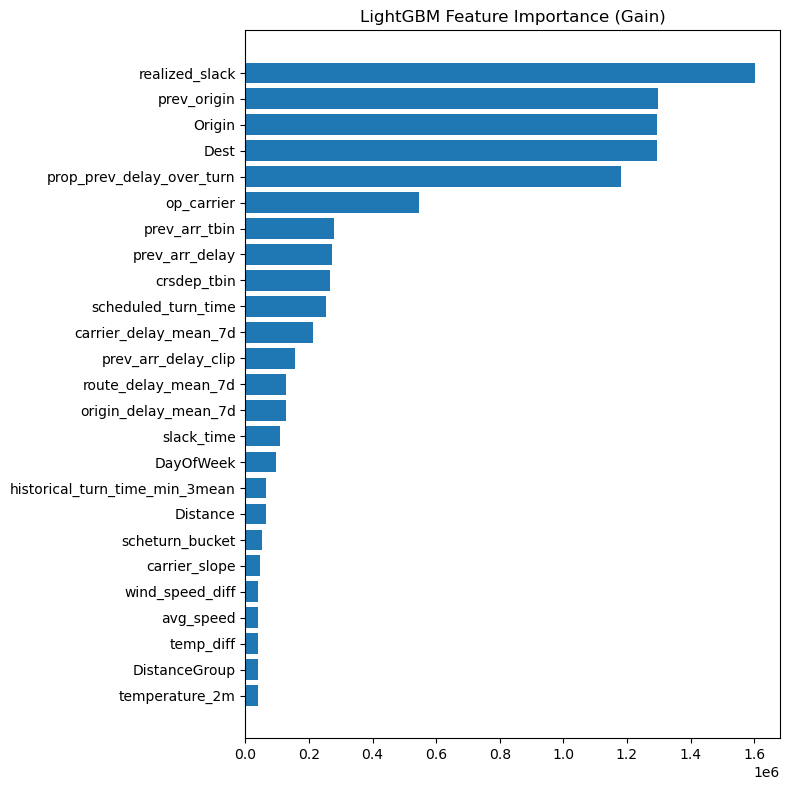

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.barh(imp_gain_df["feature"].head(25), imp_gain_df["gain_importance"].head(25))
plt.gca().invert_yaxis()
plt.title("LightGBM Feature Importance (Gain)")
plt.tight_layout()
plt.show()
